## Lab 10 Part I: Plotting Kinematic Fields
<br /><br />

In this lab, we create plots of the 300 hPa full (or total) wind and 500 hPa absolute vorticity to help us analyze the kinematic attributes of the horizontal wind field.  On the Python end of things, we continue to work to create cleaner code while also working to become more independent in creating our own code.
<br />

### Module Documentation

1. Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
2. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
3. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
4. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
5. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
6. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
7. Matplotlib Barbs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barbs.html
8. Matplotlib Color Maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
9. Matplotlib Contourf: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html
10. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [31]:
#from the dates and time code (datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module numpy and save it to np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module
import matplotlib.pyplot as plt

#from the scipy module's ndimage submodule, import the function gaussian_filter
from scipy.ndimage import gaussian_filter

#import the module xarray and save it to xr
import xarray as xr

#from the metpy submodule units, import the units function
from metpy.units import units
import metpy.calc as calc

<br /><br />
2. As with previous labs, we start by creating a function to process our data.  In the cell below, create a function that opens the dataset for the time passed to the function, selects data at the level we pass into the function, converts winds from m/s to kt, calculates the wind speed, and limits the extent of the data to 65°N-20°N and 145°W-45°W.  Finally, have the function return the dataset we have created.

In [32]:
"""
Below, a function is defined to retrieve and process GFS analysis upper-air data.  
This function opens the GFS analysis data, retains only the data on the desired
isobaric surface, converts the wind's units, calculates the ageostrophic wind and
wind speed, and adds the calculated wind variables to the dataset.

INPUT:
    level : INTEGER
        The level in hPa at which you want upper-air data.
    time : DATETIME
        The time at which you want upper-air data.
    
OUTPUT:
    leveled_data : XARRAY DATASET
        The xarray containing your processed GFS analysis data.
"""


def process_upper_air_data(level, time):
    """
    Specify the location of the upper-air data on the JupyterHub.
    """
    lab_data_loc = "/data/AtmSci360/Lab_10/"
    
    model_data = xr.open_dataset(f"{lab_data_loc}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    leveled_data = model_data.sel(isobaricInhPa =level)
    leveled_data = leveled_data.sel(latitude = slice(65,20))
    leveled_data = leveled_data.sel(longitude = slice(360-145,360-45))
    dx, dy = calc.lat_lon_grid_deltas(leveled_data["longitude"], leveled_data["latitude"])
    leveled_data['u'] = leveled_data["u"].metpy.convert_units('kt')
    leveled_data['v'] = leveled_data["v"].metpy.convert_units('kt')
    u_ageo, v_ageo = calc.ageostrophic_wind(leveled_data["gh"], leveled_data["u"], leveled_data["v"], dx=dx, dy=dy, latitude=leveled_data["latitude"])
    leveled_data = leveled_data.assign(u_ageostrophic=u_ageo)
    leveled_data = leveled_data.assign(v_ageostrophic=v_ageo)
    ageo_mag = ((u_ageo ** 2)+(v_ageo**2)) ** 0.5
    leveled_data = leveled_data.assign(ageostrophic_mag=ageo_mag) 
    mag = ((leveled_data['u']**2) + (leveled_data['v']**2)) ** 0.5
    leveled_data = leveled_data.assign(wind_mag=mag) 
    return leveled_data 

<br /><br />
3. Using the data processing function you just created, get data at 500 hPa for October 12th, 2022 at 1200 UTC.

In [33]:
map_time=datetime(2022,10,12,12)
level=500
leveled_data=process_upper_air_data(level,map_time)
leveled_data

Ignoring index file '/data/AtmSci360/Lab_10/101222_12_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  85

<xarray.Dataset>
Dimensions:           (latitude: 181, longitude: 401)
Coordinates:
    time              datetime64[ns] ...
    step              timedelta64[ns] ...
    isobaricInhPa     float64 500.0
  * latitude          (latitude) float64 65.0 64.75 64.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float64 215.0 215.2 215.5 ... 314.8 315.0
    valid_time        datetime64[ns] ...
Data variables: (12/14)
    gh                (latitude, longitude) float32 ...
    t                 (latitude, longitude) float32 ...
    r                 (latitude, longitude) float32 ...
    q                 (latitude, longitude) float32 ...
    w                 (latitude, longitude) float32 ...
    wz                (latitude, longitude) float32 ...
    ...                ...
    absv              (latitude, longitude) float32 ...
    o3mr              (latitude, longitude) float32 ...
    u_ageostrophic    (latitude, longitude) float64 <Quantity([[-6.06525834 -...
    v_ageostrophic    (latitude, longitude) float64 <Quantity([[-0.19835645  ...
    ageostrophic_mag  (latitude, longitude) float64 <Quantity([[ 6.06850097  ...
    wind_mag          (latitude, longitude) float32 <Quantity([[23.620874  24...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-12-06T10:47 GRIB to CDM+CF via cfgrib-0.9.1...

<br /><br />
4. We are ready to start creating our plots.  There are some features that the plots to be created will have in common, so let's create a function to initialize our plots and eliminate redundant code.  In the initialization function, we need to:
<ul>
    <li>Create a figure for a map.</li>
    <li>Define the map's projection.</li>
    <li>Add geographic data.</li>
    <li>Limit the plot's extent to 60°N-23°N and 125°W-65°W.</li>
    <li>Smooth the geopotential height data using a Gaussian smoother with an appropriate sigma value.</li>
    <li>Add isohypses (noting that these will be on the isobaric surface retained in the data after calling the function that you defined above) as contours.</li>
</ul>

At the function's end, we need to return the axes so that the resulting map can be passed into subsequent data plotting arguments.

In [34]:
"""
The function below is used to initialize a plot over the United States.  This function creates the plot for a map,
defines its projection, sets its extent, adds the desired geographic data, and plots isohypses (after smoothing the
data using a Gaussian filter with an appropriate sigma value) in contours.

INPUT:
    data : XARRAY DATASET
        The GFS data to use to plot isohypses.

OUTPUT:
    ax : MATPLOTLIB AXES
        The initialized plot.
"""

def initialize_plot(data):
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    fig=plt.figure(figsize=(11.5,7),dpi=300)
    ax = plt.subplot(projection = proj)
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    ax.set_extent((-125, -65, 23, 60))
    smooth_heights = gaussian_filter(data["gh"].values,2)
    cont_h = plt.contour(data["longitude"].values,data["latitude"].values, smooth_heights, np.arange(0,10000,60),linewidths=0.5, colors="black", transform=crs.PlateCarree()) 
    ax.clabel(cont_h, cont_h.levels, fmt=lambda v: format(v, '.0f'))
    return ax 


<br /><br />
5. We will first create a plot of absolute vorticity at 500 hPa.  Follow along in the comments for areas you need to fill out.

In [35]:
"""
Below, a function is defined to plot absolute vorticity data.  This function adds color-filled 
absoluted vorticity contours and wind barbs for the full wind.

INPUT:
    time : DATETIME
        The date and time for which the plot is valid.
    level : INTEGER
        The level at which the plot is valid.
    data : XARRAY DATASET
        The GFS analysis data.  
"""

def plot_vort(time, level, data):
    """
    Initialize the plot using the function you created and save the axes to ax.
    """
    
    ax=initialize_plot(data)   

              
    """
    Plot the 500 hPa absolute vorticity.  Have the dataset display the variables 
    contained within the dataset and find the variable for absolute vorticity.  
    Next, apply a Gaussian filter with a sigma value of 2 to these data.
    """
   
    smooth_vort = (gaussian_filter(data["absv"].values,2))*(10**5)
    
    
    """
    Since absolute vorticity has very small values, multiply the values by 10**5 to get the values to something easier 
    to comprehend and plot.
    """
    
    
    """
    Create color-filled contours for the absolute vorticity.  Be sure to pick an appropriate color map and style your 
    contours so they are easy to read.
    """
    cont=plt.contourf(data["longitude"].values,data["latitude"].values,smooth_vort,np.arange(-6,80,4), cmap='twilight', transform=crs.PlateCarree(), zorder=1, alpha=0.4, extend="both")            
              
    """
    Next, we need to add a color bar to provide a reference to the shaded colors.  In the lines below, create a
    color bar that is appropriately labeled.  
    
    Hint: You can find the units if you print the dataset's variable.  Also remember we multiplied vorticity by 10 ** 5.  
    """
    cbar = plt.colorbar(cont)
    cbar.set_label("Wind Speed (kt)", size=12, weight="bold")
    
       
    """
    Next, we need to add wind barbs with an appropriate spacing.
    Add appropriate styling information to make the plot easier to understand.
    """
    wind_slice_x = slice(None, None, 12)
    wind_slice_y = slice(None, None, 12)  
    ax.barbs(data["longitude"][wind_slice_x].values,data["latitude"][wind_slice_y].values,
             data["u"][wind_slice_x, wind_slice_y].values,
             data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    
    """
    You can ignore this next section, which labels some points (A-C) that are referenced later in the lab.
    """    
    if str(data.time.values) == "2022-10-12T12:00:00.000000000":
        ax.text(-96,42,"A", size=12, weight="bold", transform=crs.PlateCarree())
        ax.text(-96,53,"B", size=12, weight="bold", transform=crs.PlateCarree())
        ax.text(-78,51,"C", size=12, weight="bold", transform=crs.PlateCarree())
    
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    
    Hint: Remember that we multiplied the absolute vorticity by 10 ** 5, so make sure to include this information with its units.
    """

    plot_title= f"{str(level)} hPa Vorticity Wind plot at {time:%m/%d/%Y %H%M} UTC"
    plt.title(plot_title, weight="bold") 
    

<br /><br />
6. Call the function that you just created to plot 500 hPa absolute vorticity, using the data we retrieved earlier for October 12th, 2022 at 1200 UTC.

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


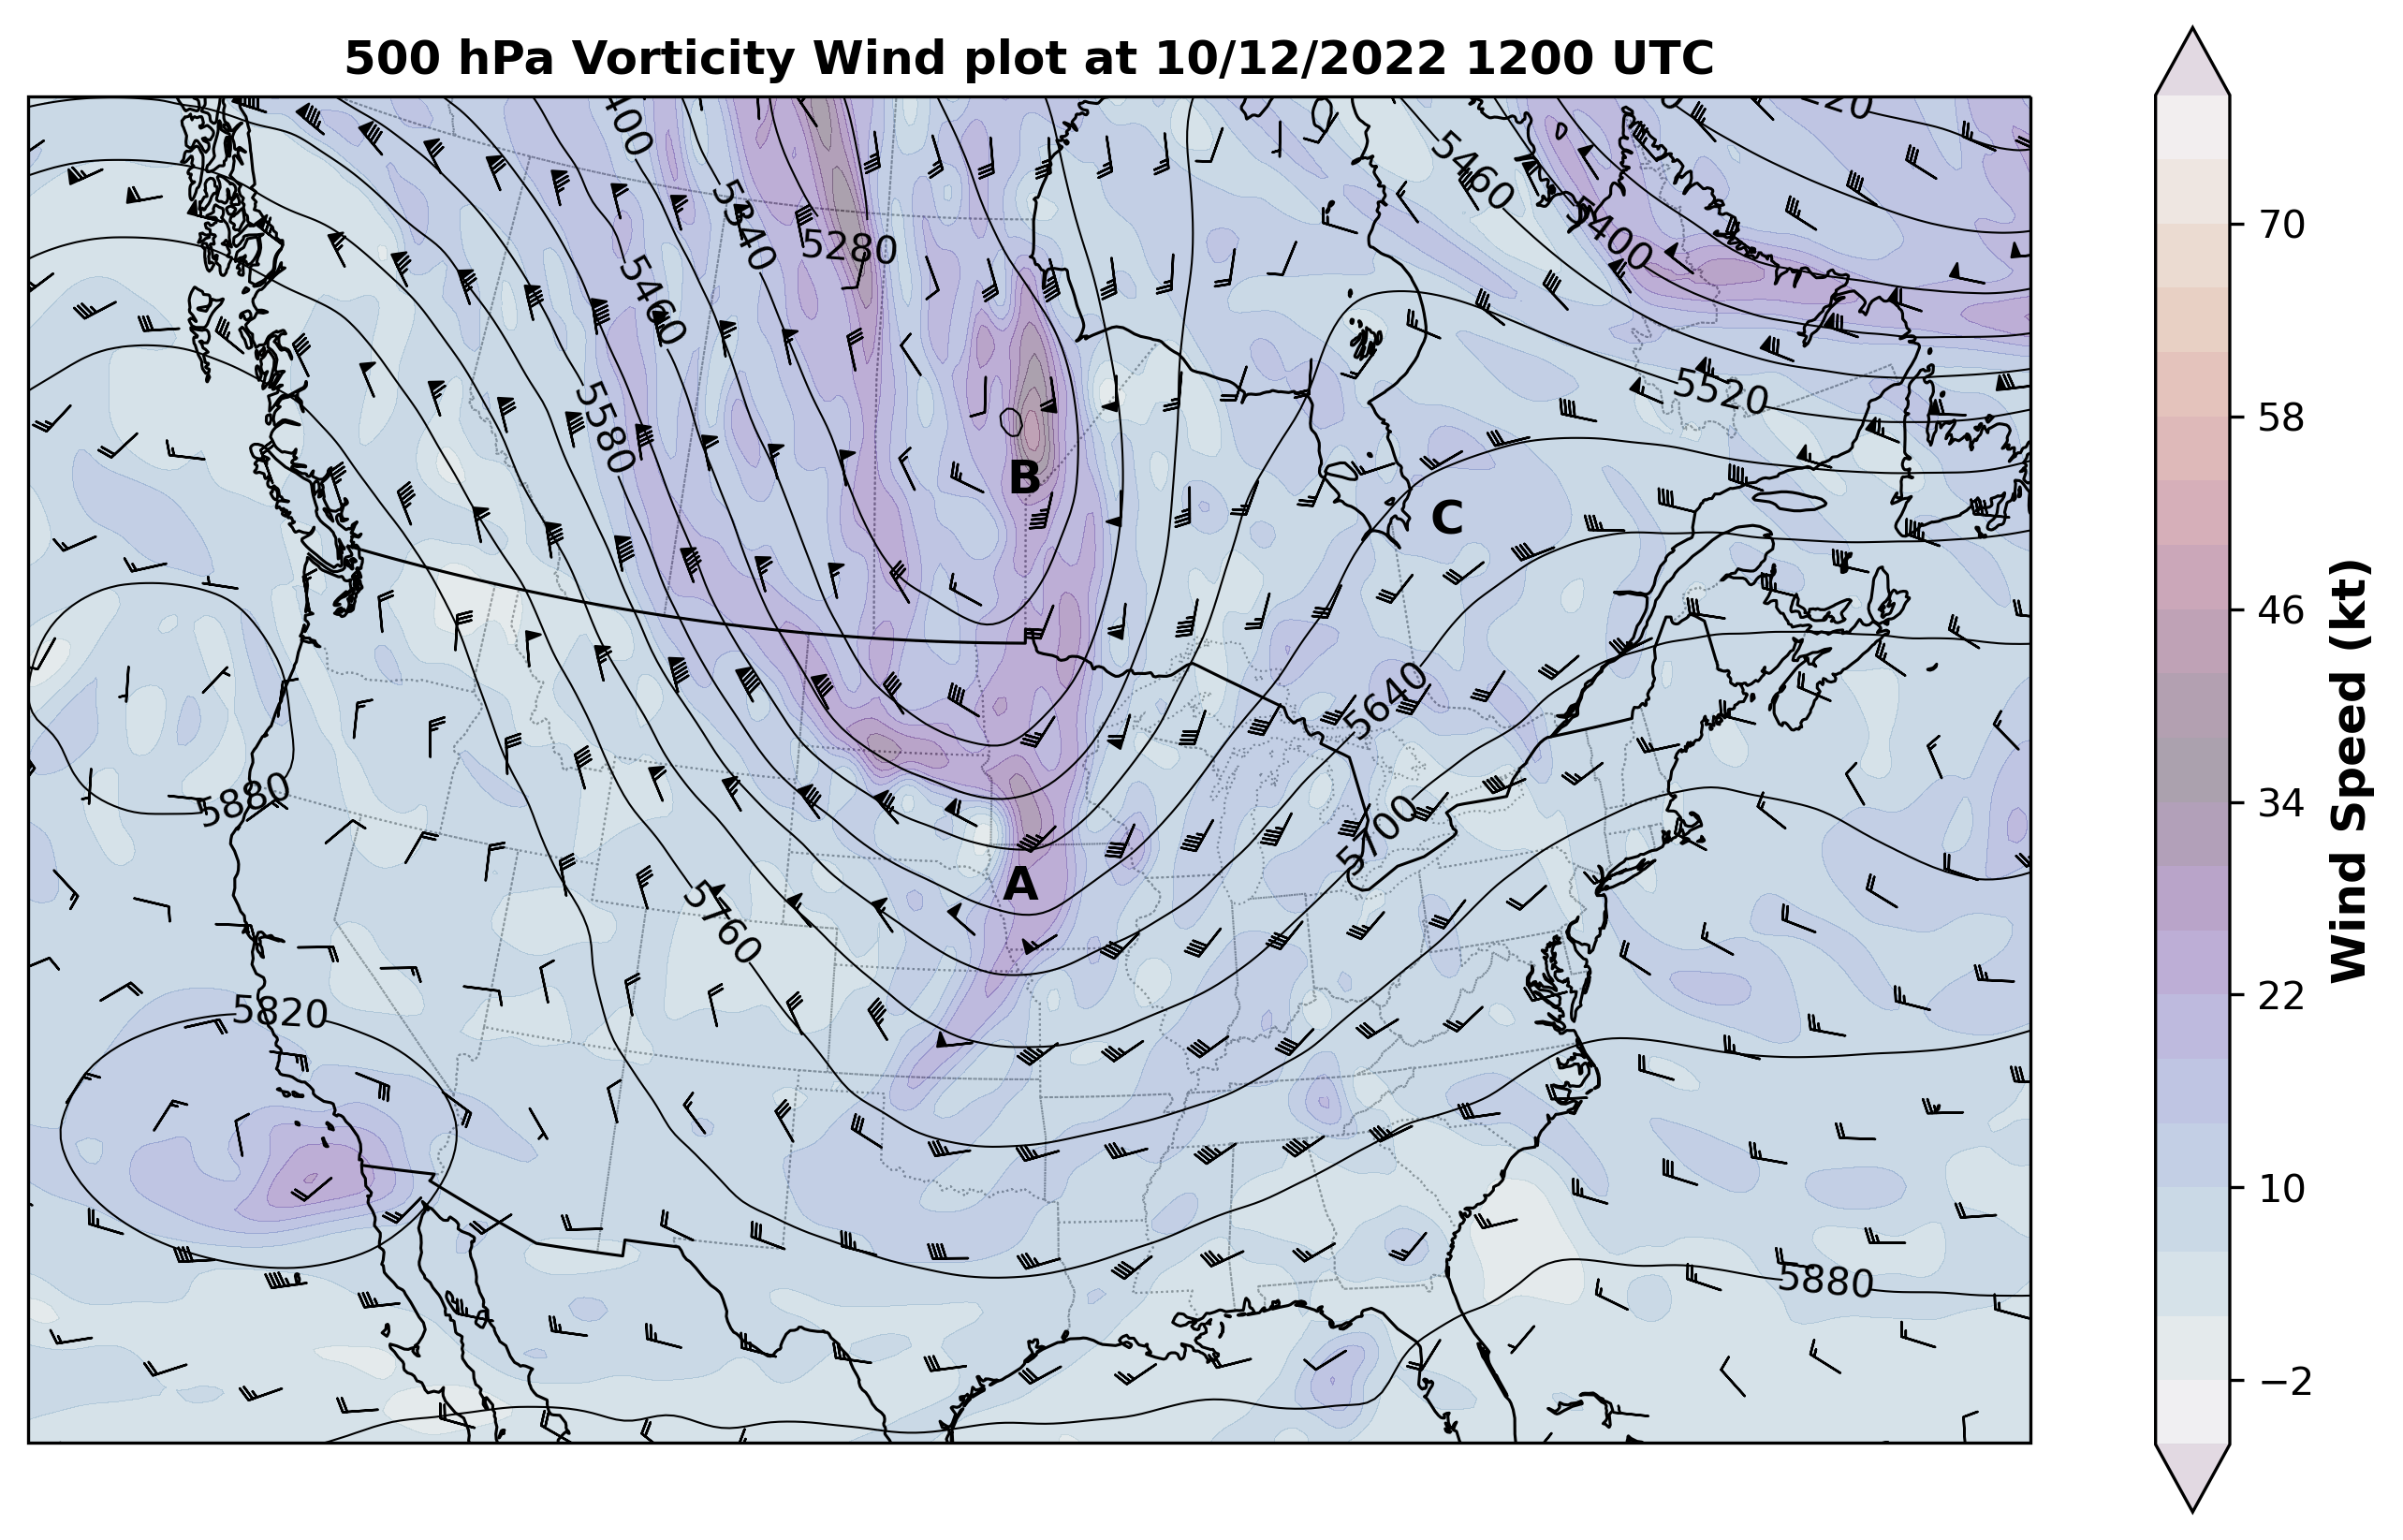

In [36]:
plot_vort(map_time,level,leveled_data)

<br /><br />
7. We also need to create a map of the full wind at 300 hPa.  Follow the instructions in the comments below for places where you need to finish the code.

In [39]:
"""
This function plots upper-air full wind data.  This function creates line isopleths for the geopotential height, color-filled isopleths 
for the wind speed, and wind barbs for the full wind.

INPUT:
    model_data : XARRAY DATASET
        The GFS analysis data.
    level : INTEGER
        The level at which the plot is valid.
    data : DATETIME
        The date and time at which the plot is valid.
"""

def plot_winds(time, level, data):
    """
    Initialize a plot using the function you created.
    """
    ax=initialize_plot(data)
              
    """
    Next, we plot color-filled contours for wind speed.  As with the geopotential height, we must first smooth the data.
    In the line below, use a Gaussian filter to smooth the wind speed data (wind_mag).
    """
    smooth_wind =gaussian_filter(data["wind_mag"].values,2) 
              
    """
    Create color-filled contours for the wind speed.  Be sure to pick an appropriate color map and style your 
    contours so they are easy to read.
    """
    cont =plt.contourf(data["longitude"].values,data["latitude"].values,smooth_wind, [40,50,75,100,150,200,225], cmap='twilight', transform=crs.PlateCarree(), zorder=1, alpha=0.6,extend="max") 
    
    """
    Next, we need to add a color bar to provide a reference to the shaded colors.  In the lines below, create a
    color bar that is appropriately labeled.  
    
    Hint: You can find the units by printing out the dataset's variable.  
    """
    cbar = plt.colorbar(cont)
    cbar.set_label("Wind Speed (kt)", size=12, weight="bold") 
    
    
    """
    Next, we want to add wind barbs with an appropriate spacing.
    Add appropriate styling information to make the plot easier to understand.
    """
    wind_slice_x = slice(None, None, 12)
    wind_slice_y = slice(None, None, 12)  
    ax.barbs(data["longitude"][wind_slice_x].values,data["latitude"][wind_slice_y].values,
             data["u"][wind_slice_x, wind_slice_y].values,
             data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    
    """
    You can ignore this next section, which labels some points (A and B) that are referenced later in the lab.
    """  
    if str(data.time.values) == "2022-10-12T12:00:00.000000000":
        ax.text(-100,42.5,"A", size=12, weight="bold", transform=crs.PlateCarree())
        ax.text(-86.5,44.5,"B", size=12, weight="bold", transform=crs.PlateCarree())
    
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    """
    plot_title= f"{str(level)} hPa full wind plot at {time:%m/%d/%Y %H%M} UTC"
    plt.title(plot_title, weight="bold")   
             


<br /><br />
8. Since the filtered data earlier in the lab are at 500 hPa, we need to first re-run the data processing function to filter the data to 300 hPa on October 12th, 2022 at 1200 UTC.  After doing so, run the full wind plotting function to plot the 300 hPa winds on October 12th, 2022 at 1200 UTC.

Ignoring index file '/data/AtmSci360/Lab_10/101222_12_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  85

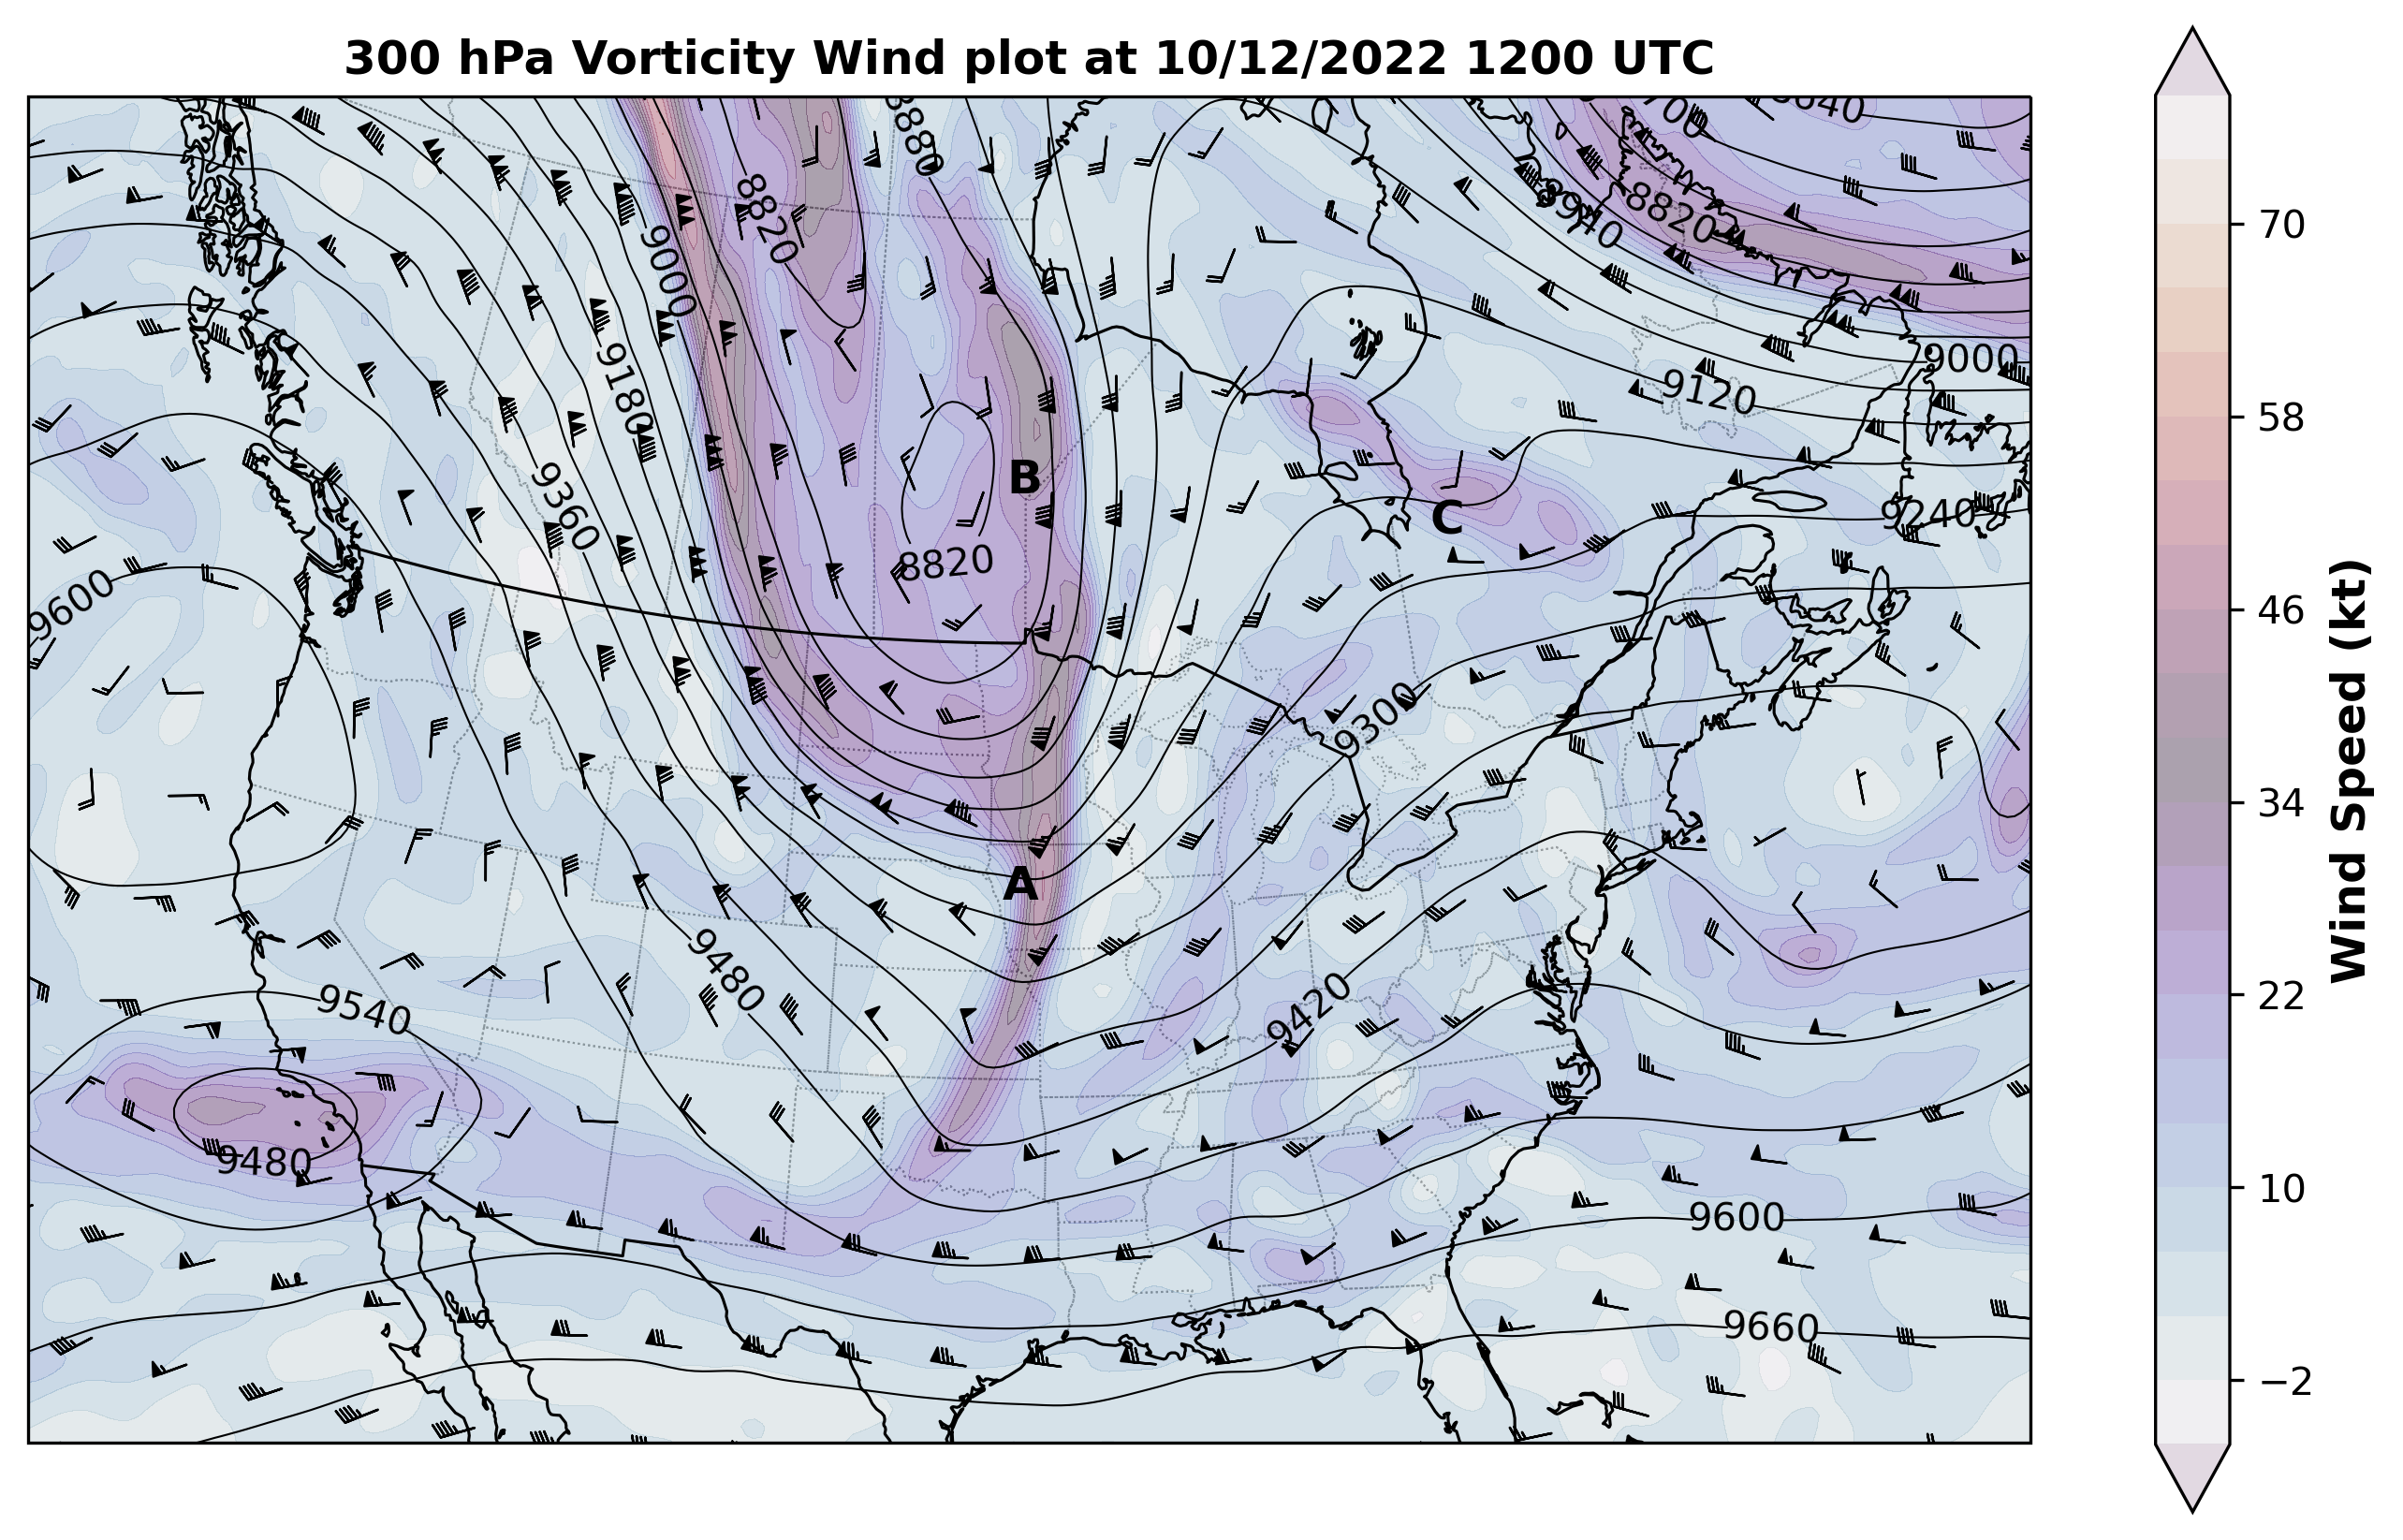

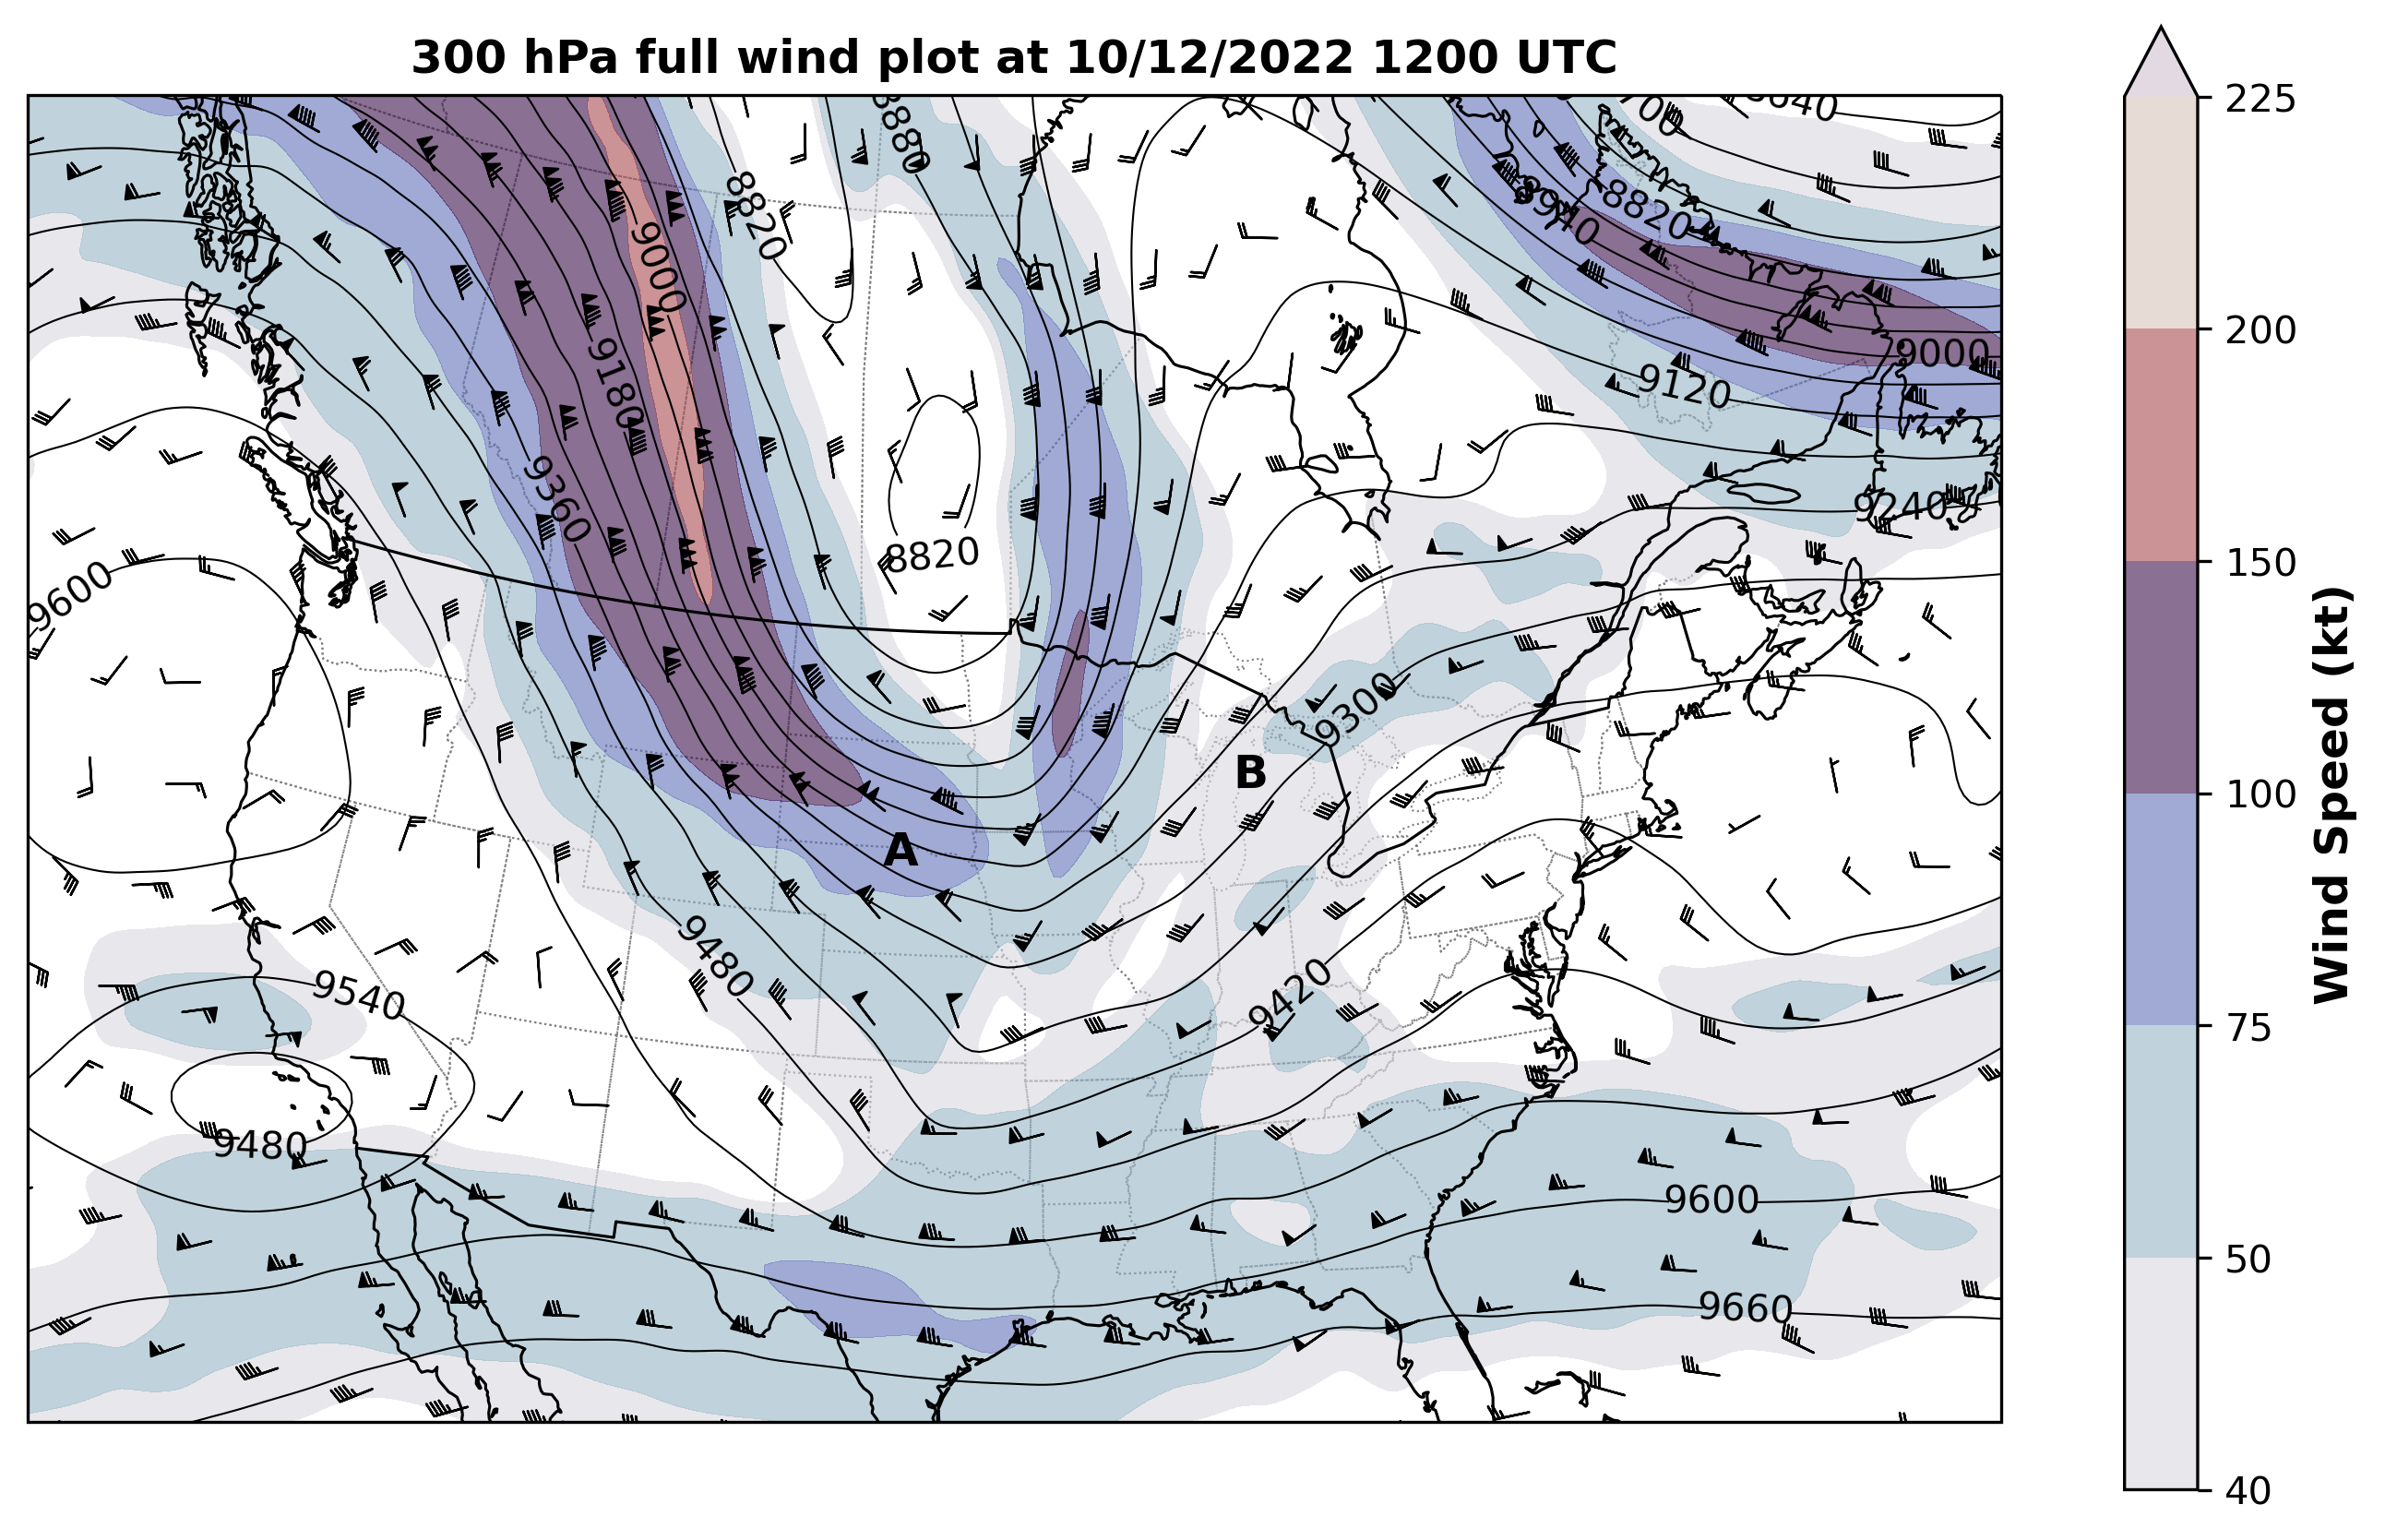

In [40]:
map_time=datetime(2022,10,12,12)
level=300
leveled_data=process_upper_air_data(level,map_time)
plot_vort(map_time,level,leveled_data)
plot_winds(map_time,level,leveled_data)

<br /><br />
9. To complete the analysis, we also need to plot 500 hPa absolute vorticity and 300 hPa winds for September 23rd, 2022 at 1800 UTC.  Re-run the data processing and plotting functions to obtain these maps. Note: as you did above, you will need to re-run the data processing function between creating these plots.

Ignoring index file '/data/AtmSci360/Lab_10/092322_18_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  85

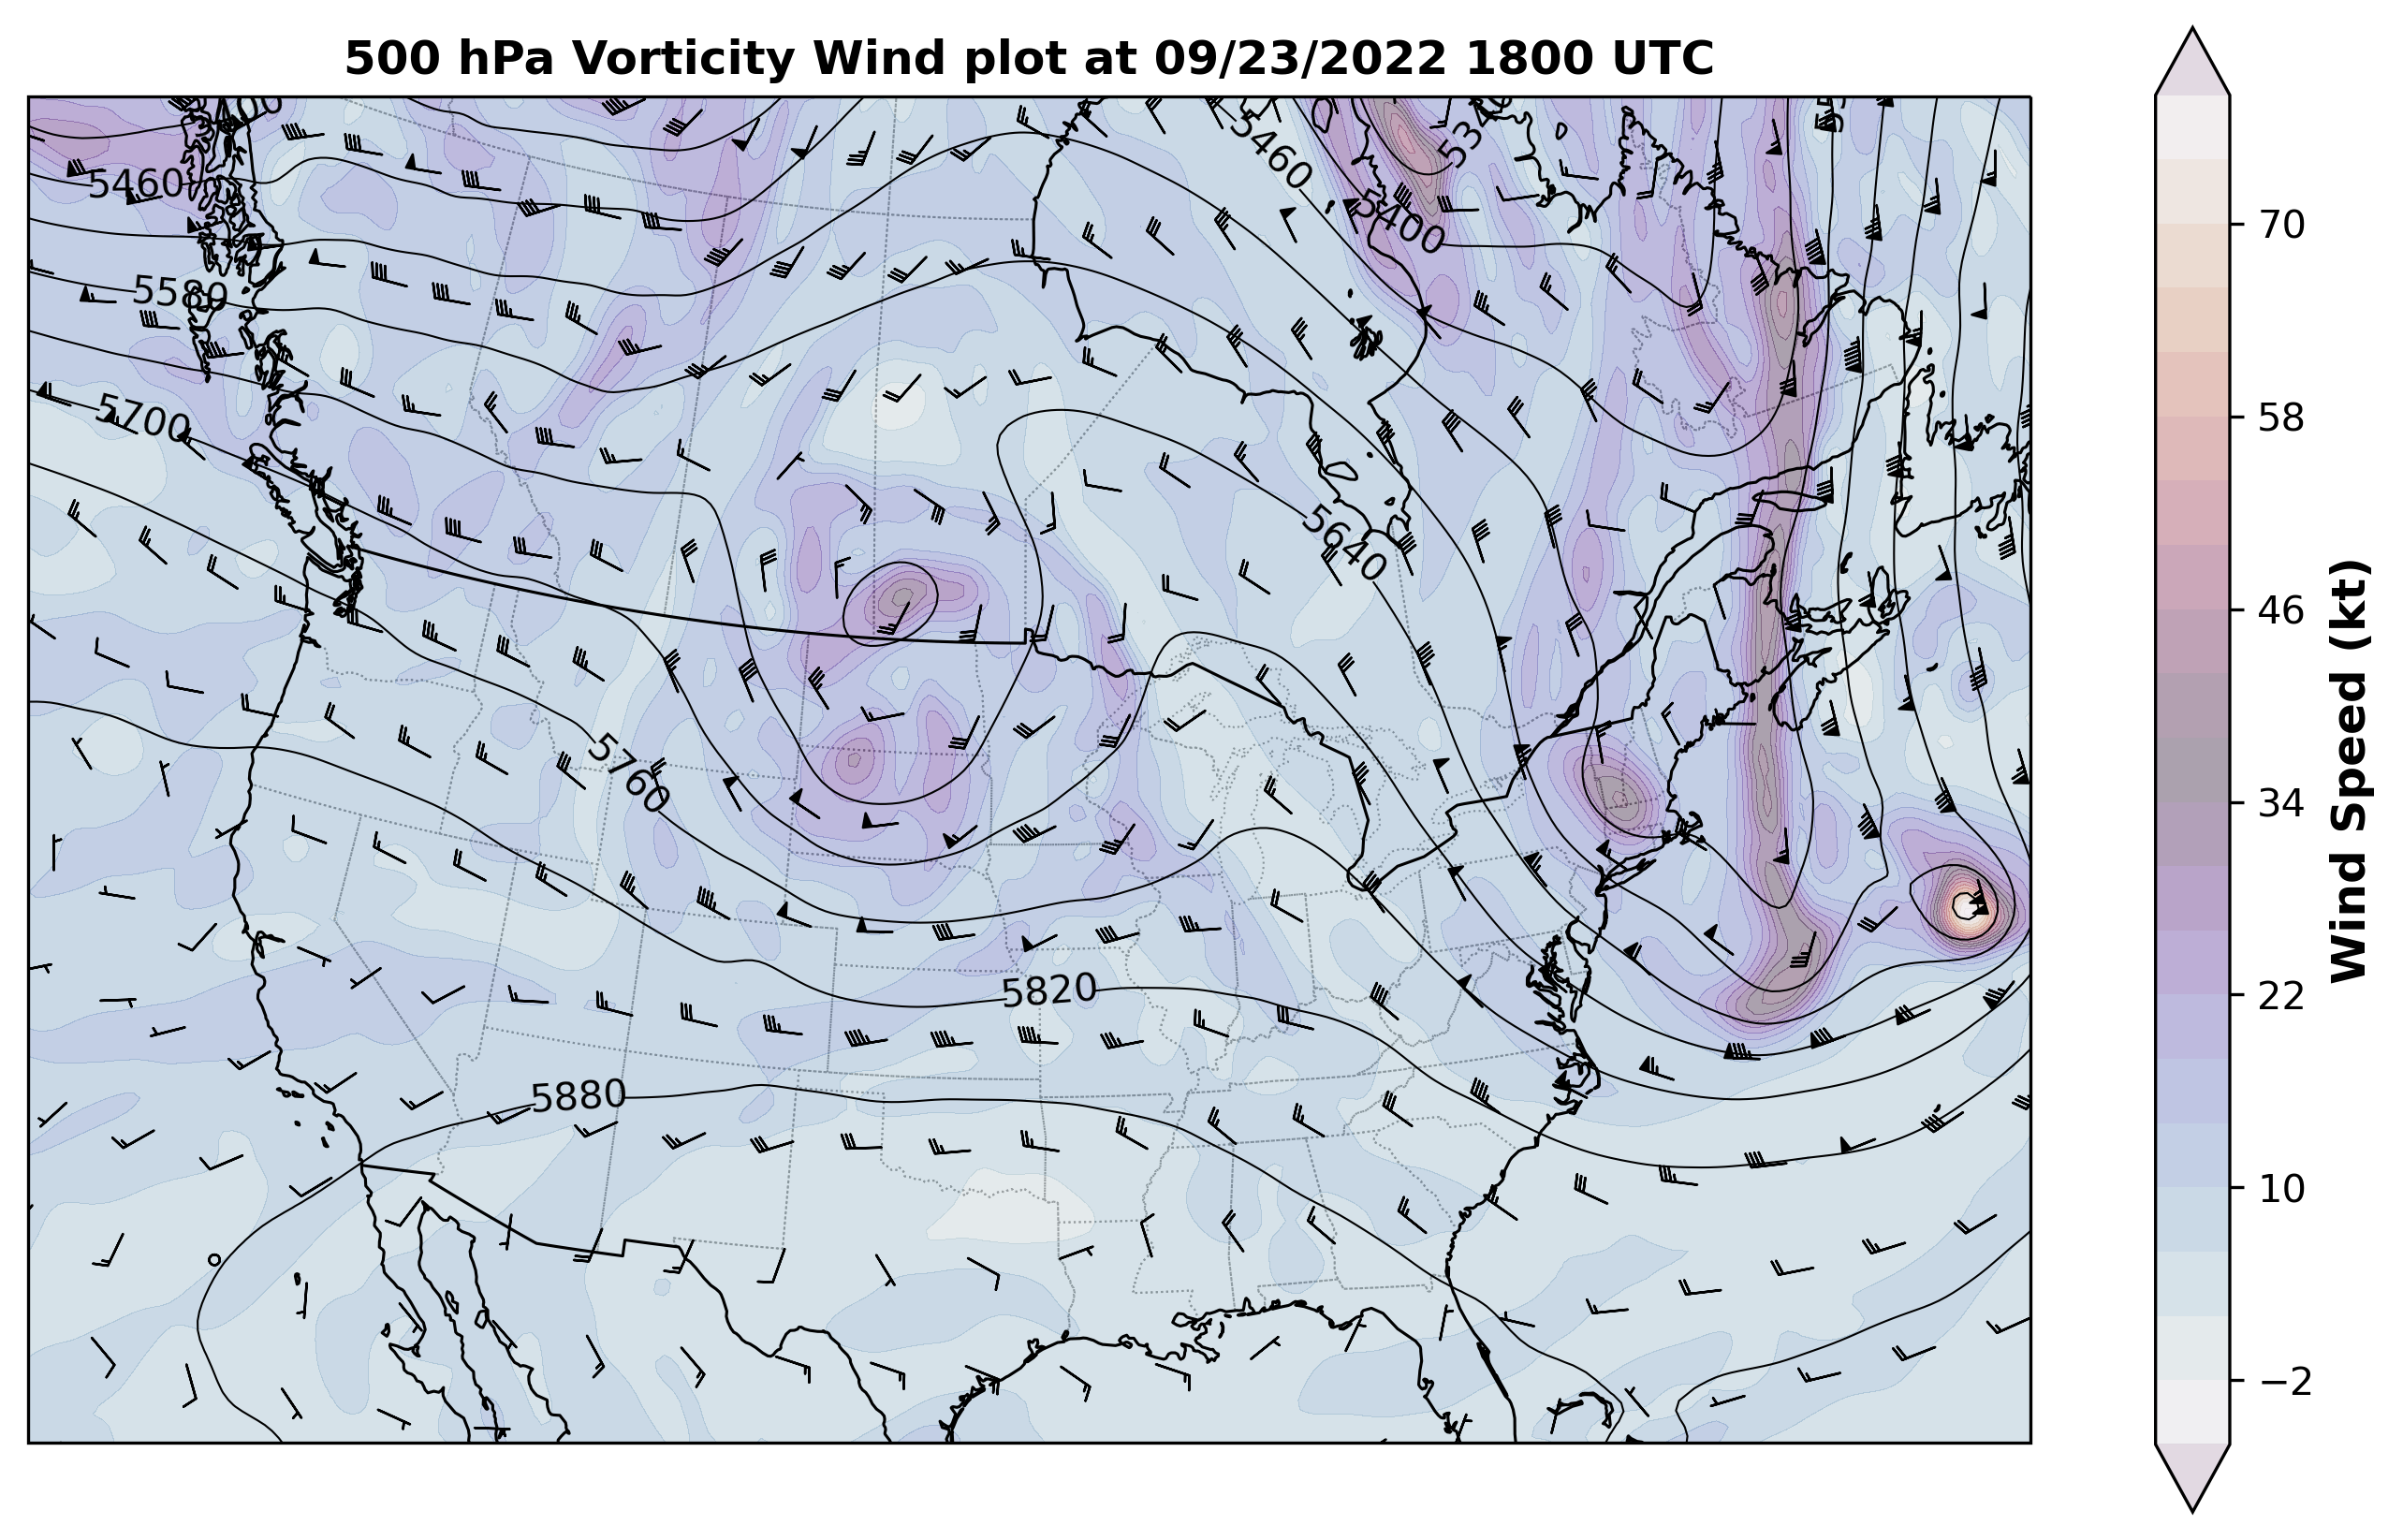

In [41]:
map_time=datetime(2022,9,23,18)
level=500
leveled_data=process_upper_air_data(level,map_time)
plot_vort(map_time,level,leveled_data)


### You have now completed Part I of the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.

Ignoring index file '/data/AtmSci360/Lab_10/092322_18_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  85

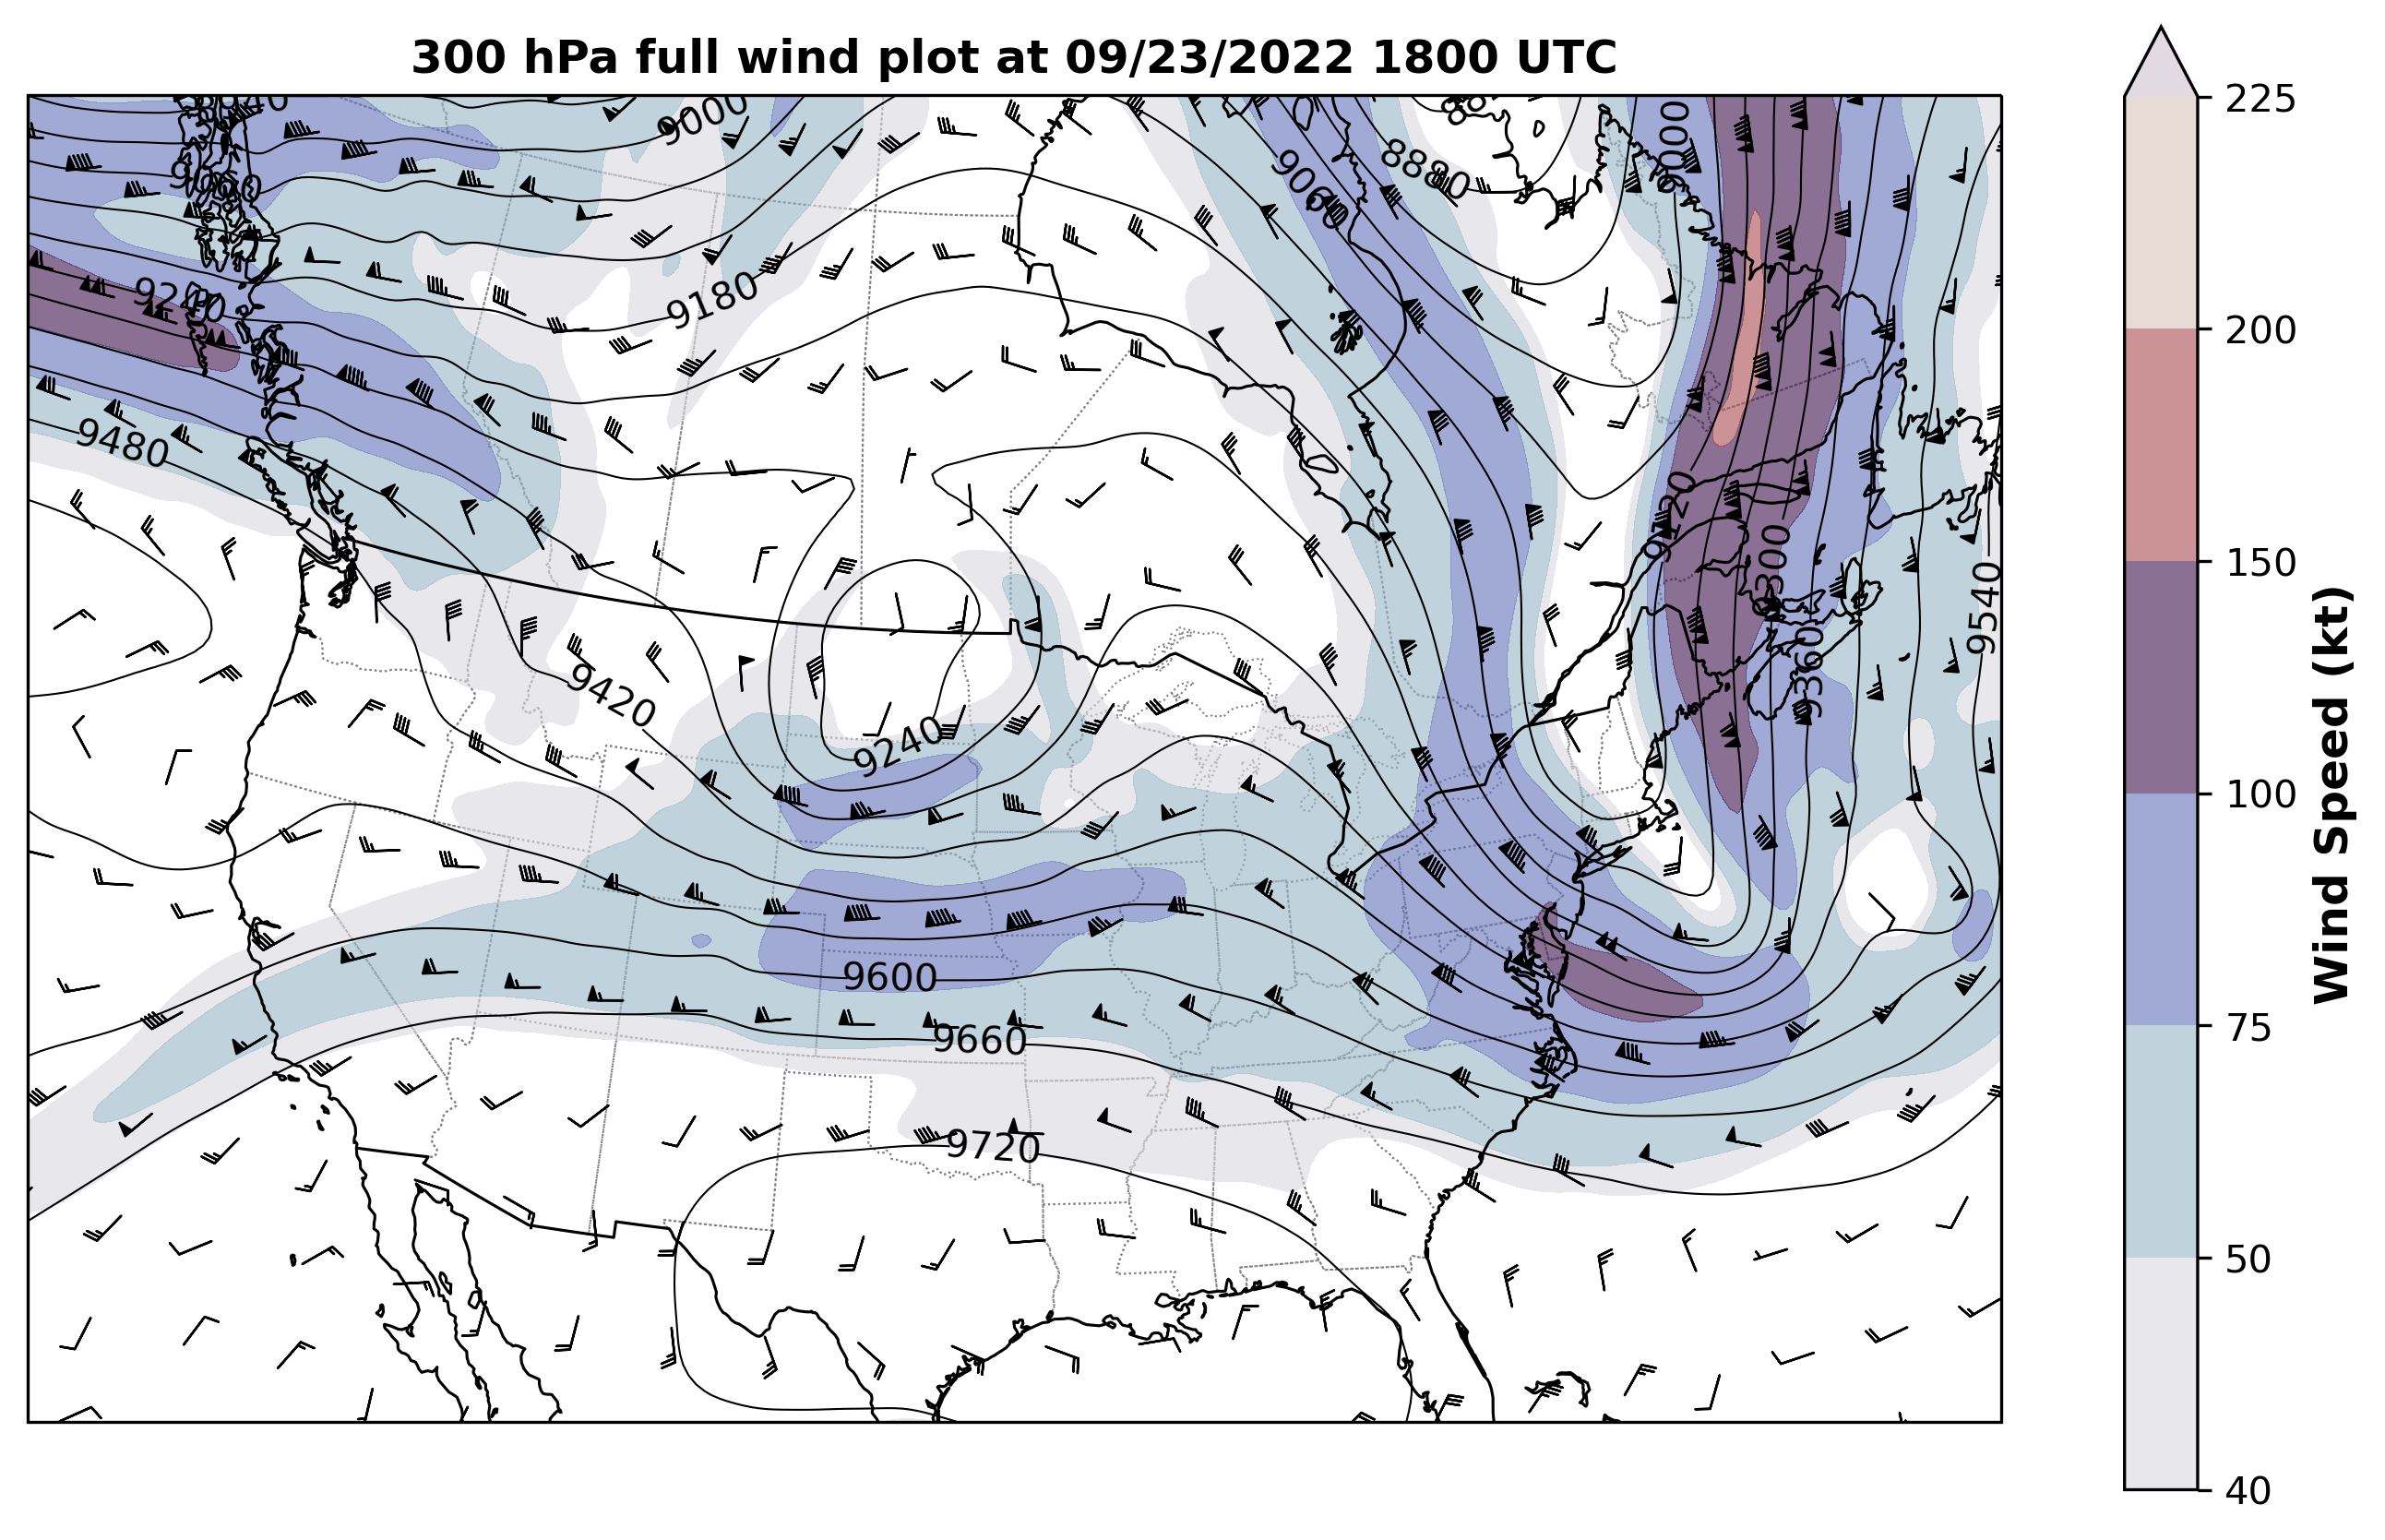

In [42]:
map_time=datetime(2022,9,23,18)
level=300
leveled_data=process_upper_air_data(level,map_time)
plot_winds(map_time,level,leveled_data)